# Unsupervised methods for time series analysis

We will be using the mortgage affordability provided by Zillow https://www.zillow.com/research/data/

The project repository includes the data and utility functions to load and plot it

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import affordability_lib.utils as utils

afford_df = utils.get_affordability_df()
afford_df.head(10)

,RegionID,RegionName,SizeRank,1979-03,1979-06,1979-09,1979-12,1980-03,1980-06,1980-09,...,2014-12,2015-03,2015-06,2015-09,2015-12,2016-03,2016-06,2016-09,2016-12,2017-03
324,394913,"New York, NY",1,0.261700,0.278316,0.284399,0.319438,0.379845,0.318970,0.337586,...,0.241961,0.240494,0.247387,0.245957,0.249606,0.241544,0.239503,0.240021,0.265376,0.269264
325,753899,"Los Angeles-Long Beach-Anaheim, CA",2,0.357694,0.388161,0.401762,0.459422,0.541508,0.464528,0.486750,...,0.383162,0.382531,0.396277,0.395686,0.402116,0.393042,0.390708,0.386895,0.430334,0.433476
326,394463,"Chicago, IL",3,0.261928,0.276790,0.276248,0.309709,0.353099,0.299344,0.295616,...,0.134913,0.134063,0.139074,0.137962,0.138784,0.134412,0.133701,0.132856,0.147025,0.149054
327,394514,"Dallas-Fort Worth, TX",4,0.301131,0.328453,0.340857,0.386321,0.452818,0.376912,0.394715,...,0.118163,0.117663,0.124935,0.128167,0.133517,0.131539,0.133219,0.135142,0.149861,0.152387
328,394974,"Philadelphia, PA",5,0.204333,0.215107,0.219247,0.247690,0.295396,0.248018,0.260259,...,0.141915,0.139100,0.142831,0.141625,0.142089,0.137387,0.135599,0.135064,0.148746,0.148559
329,394692,"Houston, TX",6,0.243178,0.265630,0.268049,0.294382,0.342770,0.291661,0.292763,...,0.112149,0.113520,0.118255,0.119155,0.122370,0.120863,0.120717,0.120675,0.132078,0.130511
330,395209,"Washington, DC",7,0.254252,0.264869,0.277353,0.314773,0.373035,0.319475,0.337635,...,0.174821,0.173381,0.178910,0.177032,0.178584,0.172367,0.169965,0.168010,0.185774,0.186239
331,394856,"Miami-Fort Lauderdale, FL",8,0.267852,0.284229,0.287053,0.332037,0.392403,0.334098,0.360938,...,0.181766,0.183585,0.194088,0.197580,0.203430,0.197855,0.198292,0.199508,0.221129,0.222176
332,394347,"Atlanta, GA",9,0.248301,0.264578,0.271742,0.312490,0.371988,0.307385,0.322451,...,0.113326,0.113214,0.117454,0.118066,0.120754,0.117895,0.117187,0.116937,0.130104,0.131081
333,394404,"Boston, MA",10,0.222021,0.237248,0.239940,0.276893,0.316496,0.271210,0.285134,...,0.212892,0.210786,0.216809,0.217371,0.221722,0.215844,0.214103,0.212644,0.236357,0.239656


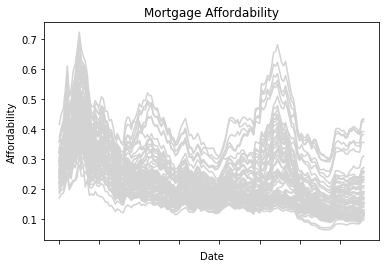

In [3]:
import matplotlib.pylab as plt

utils.plot_affordability_series(afford_df)
plt.show()

## Task I: Clustering

(1) Use the kmeans algorithm to cluster the timeseries data. The
implementation of kmeans for sklearn is described here:
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

You need to make some choices: 
  - Preprocessing: should you scale and center data before clustering?
  - Initialization: How will you choose starting centroids
  - Evaluation: How will you determine the number of clusters to use for next steps of analysis. Here are options implemented in sklearn: http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation. Here is an implementation of the gap statistic method shown in lecture (use at your discretion): https://github.com/Zelazny7/gap-statistic/blob/master/gap.py
  
Make sure to include your choices for the above in your writeup.

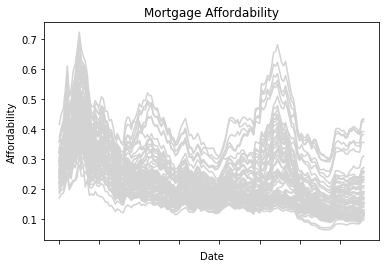

In [4]:
# clustering code goes here
import affordability_lib.utils as utils
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from numpy.random import random_sample
from math import sqrt, log

afford_df = utils.get_affordability_df()
afford_df.head(10)

utils.plot_affordability_series(afford_df)
plt.show()


1. Normalization: z will now be 0 ≤ z ≤ 1 : z = (x-min(x))/(max(x) - min(x))
        preprocessing.normalize(z): All the values are all now between 0 and 1-> makes training less sensitive to the scale of features, so we can better solve for coefficients.

2- Standardization:
    Z is rescaled such that M = 0 and sigma = 1,z = xi-M / sigma   
    1. Compare features that have different units or scales
    2. We can compare features and use them in our models once we have standardized them
    implemented in scikit-learn; they might behave badly if the individual features
    do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

Given enough time, K-means will always converge, however this may be to a local minimum. This is highly dependent on 
the initialization of the centroids. As a result, the computation is often done several times, with different initializations
 of the centroids. One method to help address this issue is the k-means++ initialization scheme, which has been implemented in 
 scikit-learn (use the init='k-means++' parameter). This initializes the centroids to be 
(generally) distant from each other, leading to provably better results than random initialization, as shown in the reference

In [5]:
import time
from sklearn import cluster, mixture
from sklearn.metrics.pairwise import pairwise_distances_argmin


def iter_kmeans(df, n_clusters, num_iters=5):
    rng =  range(1, num_iters + 1)
    vals = pd.Series(index=rng)
    for i in rng:
        k = KMeans(n_clusters=n_clusters, n_init=3)
        k.fit(df)
        print( "Ref k: %s" % k.get_params()['n_clusters'])
        vals[i] = k.inertia_
    return vals


def scale_data(feature_map_matrix):
    from sklearn import preprocessing
    X_std = preprocessing.scale(feature_map_matrix)
    print('scaling features by Standardization') # zero mean and unit variance.
    print (X_std)
    print('mean', np.mean(X_std))
    print('variance' , np.var(X_std))
    
    ''' Standardization usiing StandardScaler '''
    #from sklearn.preprocessing import StandardScaler
    #X_std = StandardScaler().fit_transform(feature_map_matrix) # standardized vector
    return X_std

def normalize_data(feature_map_matrix):
    from sklearn import preprocessing
    X_std = preprocessing.normalize(feature_map_matrix)
    print('scaling features by Normalization') # zero mean and unit variance.
    print (X_std)
    print('mean', np.mean(X_std))
    print('variance' , np.var(X_std))
    
    ''' Standardization usiing StandardScaler '''
    #from sklearn.preprocessing import StandardScaler
    #X_std = StandardScaler().fit_transform(feature_map_matrix) # standardized vector
    return X_std


def plot_feature_map(X):
    global fieldnames
    plt.matshow(X)
    plt.colorbar()
    plt.xlabel('Features')
    plt.ylabel('Users')
    plt.title('Scaled Feature Map')
    #plt.xticks(X, fieldnames, rotation='vertical')
    

    
def get_PCA(X, n_components):
    global feature_map_matrix
    from sklearn import decomposition
    pca = decomposition.PCA(n_components=n_components) # creates a PCA object
    pca.fit(X) # Fit the model with X
    print("The amount of variance explained by each of the selected components: ", pca.explained_variance_ratio_) #[0.84915802 0.14771792]
    print("singular values : ", pca.singular_values_)  # [3613962.10785618 1507321.59978545]
    print('\nPC 1 with scaling:\n', pca.components_[0])
    print('\nPC 2 with scaling:\n', pca.components_[1])
    X_PCA = pca.transform(X)#Apply dimensionality reduction to X.
    print (X_PCA.shape)
    return X_PCA


def plot_PCA(X_PCA, n_components):
    if n_components==2:
        plt.figure(figsize=(6, 4))
        plt.scatter(X_PCA[:,0], 
                    X_PCA[:,1],
                    marker='.')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.show()
    elif n_components==3:
        ''' plotting PCA with 3 components'''
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(1, figsize=(4, 3))
        plt.clf()
        ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
        ax.scatter(X_PCA[:, 0], 
                   X_PCA[:, 1], 
                   X_PCA[:, 2])
        plt.title('PCA')


In [6]:
#Task I: Clustering


colors = ['#4EACC5', '#FF9C34', '#4E9A06']
n_clusters = 3 # initial cluster number
clustering_labels = list()


# Preprocessing:
dat = afford_df.drop(columns=['RegionName', 'SizeRank', 'RegionID']).values
X_std = scale_data(dat) 
X_nrm = normalize_data(dat)



# clustering
k_means = cluster.KMeans(n_clusters = n_clusters, init='k-means++', random_state=0, n_init=10)
t0 = time.time()
clustering_labels = k_means.fit(X_std).labels_
t1 = time.time()
t_batch = time.time() - t0
k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)


scaling features by Standardization
[[-0.16133989 -0.18232166 -0.19160689 ...  1.00467347  0.99586909
   1.01192586]
 [ 1.88122703  1.91280029  1.90822046 ...  2.98489658  3.00599867
   2.9936155 ]
 [-0.15648979 -0.21141962 -0.33743993 ... -0.44018351 -0.44631603
  -0.43875541]
 ...
 [ 0.74042932  0.58107055  0.66606284 ...  1.42786141  1.46237808
   1.49128273]
 [ 0.21819037  0.10992871  0.19160257 ...  0.97916066  1.01068862
   1.03787358]
 [-0.96034732 -0.94853789 -0.72627015 ... -0.71168597 -0.71864631
  -0.71482741]]
mean -7.74011694727778e-18
variance 1.0
scaling features by Normalization
[[0.06496952 0.06909448 0.0706046  ... 0.0595875  0.06588198 0.06684725]
 [0.06794556 0.07373281 0.07631653 ... 0.07349246 0.08174385 0.08234063]
 [0.09084035 0.0959947  0.09580654 ... 0.04607614 0.05099025 0.05169389]
 ...
 [0.08434126 0.08829625 0.09217825 ... 0.07527943 0.0842244  0.08570178]
 [0.08181809 0.0859454  0.08951005 ... 0.06969832 0.07802917 0.07944058]
 [0.09355798 0.09939911 0.10

_Clustering discussion goes here_

(2) Further analysis: Plot the resulting cluster centroids and provide a qualitative description of each cluster. Look at the region names and size ranks for the time series you obtain, do resulting clusters reflect geographic or population similarities across regions?

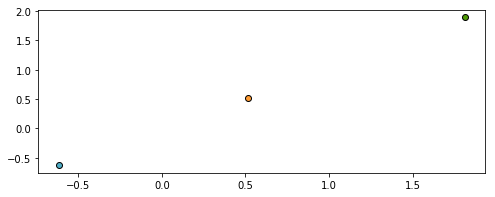

In [7]:
# clustering analysis goes here
fig1 = plt.figure(figsize=(8, 3))
ax = fig1.subplots()
for k, col in zip(range(n_clusters), colors):
    my_members = clustering_labels == k
    cluster_center = k_means_cluster_centers[k]
    
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)

_with discussion here_

## Task 2: Dimensionality Reduction via Decomposition
    
(1) Apply one  "global" dimensionality reduction technique, e.g., PCA or Non-negative Matrix Factorization (http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) to the affordability data. 

The amount of variance explained by each of the selected components:  [0.86061575 0.06356422]
singular values :  [99.37588075 27.00739594]

PC 1 with scaling:
 [0.0698346  0.07113462 0.07329975 0.0744361  0.07607485 0.07612838
 0.07631619 0.0750472  0.07491858 0.07478599 0.07293573 0.0659504
 0.07241541 0.07189989 0.07010501 0.06766091 0.07067001 0.07166126
 0.07185996 0.07208038 0.07287222 0.07291123 0.0735319  0.07409454
 0.07480974 0.07486589 0.07496364 0.0753147  0.07475154 0.07362381
 0.07457371 0.07470726 0.0749081  0.0754792  0.07596257 0.07633518
 0.0775085  0.07755247 0.0793803  0.08058627 0.08148936 0.08235158
 0.08271627 0.08290039 0.08340877 0.08358381 0.08364375 0.08373468
 0.08381157 0.08380646 0.08396665 0.08399777 0.0841639  0.08452158
 0.08463269 0.08491089 0.08509368 0.08529649 0.0854521  0.08553947
 0.08553013 0.08525081 0.08484531 0.08472963 0.08444902 0.08425975
 0.0841073  0.08378779 0.0837964  0.08327059 0.082975   0.08261041
 0.08267262 0.08254402 0.08236397 0.0

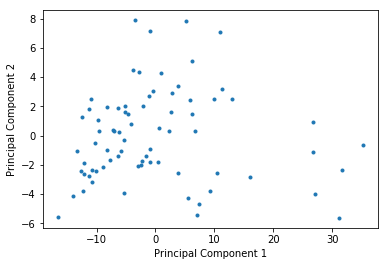

The amount of variance explained by each of the selected components:  [0.99501246 0.00498754]
singular values :  [27.14044486  1.92152512]

PC 1 with scaling:
 [0.0625713  0.06542689 0.07039942 0.07259342 0.07508481 0.07615195
 0.07404126 0.07200545 0.07233615 0.07055295 0.06800537 0.0545043
 0.06736893 0.06287516 0.06153753 0.05740084 0.06170631 0.06362225
 0.06507038 0.06437546 0.06326071 0.06311922 0.06282513 0.06368905
 0.06423676 0.06330239 0.06348887 0.06343    0.06210814 0.0599382
 0.06121542 0.06171074 0.06178695 0.06308259 0.06473305 0.06605856
 0.06892843 0.0707837  0.07470976 0.07847013 0.0823988  0.08484539
 0.08643988 0.08653472 0.08705554 0.08714838 0.08692878 0.08665533
 0.08637362 0.08653808 0.08695047 0.08694404 0.08682659 0.08698011
 0.08691255 0.08675643 0.08681214 0.08654787 0.08637521 0.08611109
 0.08560348 0.08502227 0.08468659 0.08449442 0.08418254 0.08383914
 0.08331476 0.08287073 0.08205598 0.08161035 0.08119668 0.08125484
 0.08157742 0.08194833 0.08231811 0.08

In [10]:
# decomposition code here

n_components = 2                #We chose first two components
X_PCA = get_PCA(X_std, n_components)
plot_PCA(X_PCA, n_components)
CENTROID_PCA = get_PCA(k_means_cluster_centers, n_components)

(2) Plot the transformed data in two dimensions. Color regions based on clusters found in Task 1. Plot again coloring based on geography or size. Does the data in reduced dimension reflect any of these characteristics?

clustering_labels 0
[False False False  True  True  True False False  True False False  True
 False False False  True False  True  True  True False  True False  True
 False  True  True  True  True False  True  True False  True False  True
  True  True  True  True  True False  True False False False  True False
 False  True False  True False  True  True  True False  True False  True
  True  True  True False False  True  True False  True False  True False
 False False  True]
[-0.61526908 -0.63108301 -0.62088724 -0.62763418 -0.62302717 -0.60857943
 -0.63041711 -0.62561949 -0.62432725 -0.64156247 -0.61591891 -0.59531127
 -0.61481149 -0.63523707 -0.61974405 -0.60372213 -0.63953957 -0.62689295
 -0.62344414 -0.62412875 -0.63810676 -0.64285546 -0.64340057 -0.64192858
 -0.64432807 -0.64395267 -0.63957618 -0.64120371 -0.64675993 -0.64254339
 -0.63989632 -0.63291438 -0.63365743 -0.62871911 -0.61893978 -0.60921714
 -0.61292688 -0.59596551 -0.6062015  -0.60122313 -0.59389313 -0.5926601
 -0.591566  

Text(-3.5,1.8,'train time: 0.22s\ninertia: 2755.126016')

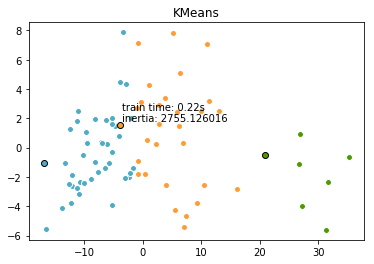

In [11]:
# plotting code here
fig2, ax2 = plt.subplots()

for k, col in zip(range(n_clusters), colors):
    my_members = clustering_labels == k
    print('clustering_labels %d'% k)
    print(my_members)
    print(k_means_cluster_centers[k])
    cluster_center = CENTROID_PCA[k]
    ax2.plot(X_PCA[my_members, 0], X_PCA[my_members, 1], 'w',
            markerfacecolor=col, marker='o')
    ax2.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax2.set_title('KMeans')
plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % ( t_batch, k_means.inertia_))

_decomposition discussion here_

*Comment: As it is shown, clusters' centriod were not selected approperiately and don't reflect the separation of clusters. 

## Task 3: Dimensionality Reduction via Manifold Learning
    
(1) Apply one  "local" dimensionality reduction technique, e.g., LLE or tSNE (http://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold) to the affordability data. 

In [12]:
# manifold code here

from sklearn import manifold

n_neighbors = 10 # number of neighbors to consider for each point.
n_components = 2 #number of coordinates for the manifold
lle_methods = ['standard', 'ltsa'] # 'hessian','modified', removed since throws an error
labels = ['LLE', 'LTSA'] #'Hessian LLE',
manifolds_leanrned = dict()
time_manifold = dict()
    
for i, method in enumerate(lle_methods):
    t0 = time.time()
    manifold_labels = manifold.LocallyLinearEmbedding(n_neighbors, 
                                                      n_components,eigen_solver='auto', 
                                                      method=method).fit_transform(dat)
    manifolds_leanrned[labels[i]] = manifold_labels
    t1 = time.time()
    time_manifold[labels[i]] = t1 - t0
    print("%s: %.2g sec" % (lle_methods[i], t1 - t0))
            
t0 = time.time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
manifold_labels = tsne.fit_transform(dat)
manifolds_leanrned['TSNE'] = manifold_labels
t1 = time.time()
time_manifold['TSNE'] = t1 - t0
print("t-SNE: %.2g sec" % (t1 - t0))

standard: 0.47 sec
ltsa: 0.016 sec
t-SNE: 0.87 sec


(2) Plot the transformed data in two dimensions. Color regions based on clusters found in Task 1. Plot again coloring based on geography or size. Does the data in reduced dimension reflect any of these characteristics?

C:\Users\yazdan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


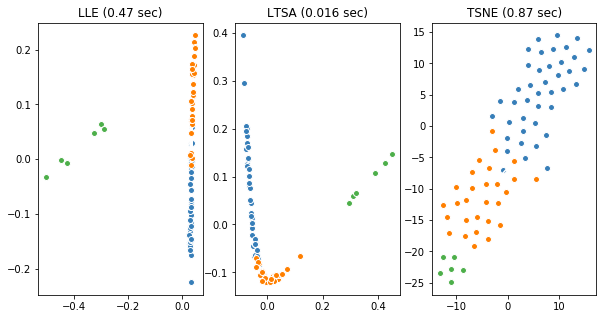

In [13]:
# plotting code here

from itertools import cycle,islice
plot_num = 131

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(plot_num)

X_TSNE = manifolds_leanrned['TSNE'] 
manifold_learning_methods = ['LLE', 'LTSA','TSNE']



colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                     '#f781bf', '#a65628', '#984ea3',
                                                     '#999999', '#e41a1c', '#dede00']),
                                              int(max(clustering_labels) + 1))))

for i, method in enumerate(manifold_learning_methods):
    projected_data = manifolds_leanrned[method] 
    ax = fig.add_subplot(plot_num)
    for k, col in zip(range(n_clusters), colors):
        my_members = clustering_labels == k

        #cluster_center = k_means_cluster_centers[k]
        ax.plot(projected_data[my_members, 0], projected_data[my_members, 1], 'w',
                markerfacecolor=col, marker='o')
        
        
        plt.title("%s (%.2g sec)" % (method, time_manifold[method]))
        
        plt.axis('tight')
    plot_num+=1

_manifold discussion here_

*Comment: As it is shown, manifold methods could underestand the clusters' separations. Manifold clustering performed much better than K-means in this problem. 